In [1]:
# Imports
import random

import numpy as np
import pandas as pd
import shap
import sklearn
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble._hist_gradient_boosting.common import X_BITSET_INNER_DTYPE
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split


C:\Users\DanPe\Desktop\ml-course\venv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\DanPe\Desktop\ml-course\venv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(al

# Preprocess

In [2]:
def smote_train_set(X, y, iterations=100):
    try:
        # {'not majority', 'auto', 'not minority', 'minority', 'all'}
        smote = SMOTE(random_state=42)
        # Generate synthetic samples
        for i in range(iterations):
            print('Processing smote iteration %d, dataset size: %d.' % (i, len(X)))
            # Randomly select a subset of rows from X and y
            random_indices = np.random.choice(len(X), size=random.randint(int(0.5 * len(X)), len(X) - 1),
                                              replace=False)
            X_subset, y_subset = X[random_indices], y[random_indices]
            # Apply SMOTE on the subset of rows
            X_synthetic, y_synthetic = smote.fit_resample(X_subset, y_subset)
            # Find the indices of rows not selected in the random subset
            non_selected_indices = np.setdiff1d(np.arange(len(X)), random_indices)
            # Concatenate the synthetic samples with the non-selected rows
            X = np.concatenate((X[non_selected_indices], X_synthetic), axis=0)
            y = np.concatenate((y[non_selected_indices], y_synthetic), axis=0)
        return X, y
    except Exception as e:
        print('Exception %s occurred during smote_train_set.' % e)

def preprocess_data(strategy='most_frequent', smote=False, iterations=100):
    try:
        train_set = pd.read_csv('train.csv')
        # train_set = pd.concat([train_set] * 20, ignore_index=True)
        test_set = pd.read_csv('validation_and_test.csv')
        X_test = test_set.iloc[:, 1:]
        X = train_set.iloc[:, :-1]
        y = train_set.iloc[:, -1]
        if strategy:
            imp = SimpleImputer(strategy=strategy)
            X_imputed = imp.fit_transform(X)
            X_test_imputed = imp.fit_transform(X_test)
        else:
            X_imputed = X
            X_test_imputed = X_test
        if smote:
            X_imputed, y = smote_train_set(X_imputed, y, iterations)
        return X_imputed, y, X_test_imputed
    except Exception as e:
        print('Exception %s occurred during preprocess_data.' % e)

# Training


In [7]:
try:
    for strategy in ['most_frequent']:  # ['mean', 'median', 'most_frequent', 'constant']:
        try:
            print('Preprocessing data.')
            X_imputed, y, X_test_imputed = preprocess_data(strategy=strategy, smote=False,
                                                                             iterations=300)
            print('X len is: %s' % str(X_imputed.shape))
            clf = ExtraTreesClassifier(max_features='sqrt', max_leaf_nodes=31,
                                       n_estimators=2000, n_jobs=-1, random_state=12032022, max_depth=2000,
                                       criterion="gini")
            print('Fitting model.')
            clf.fit(X_imputed, y)
            y_pred = clf.predict(X_imputed)
            auc = sklearn.metrics.roc_auc_score(y, y_pred)
            print(f"TRAIN AUC = {auc}")
        except Exception as e:
            print('Exception %s occurred during run for strategy %s.' % (e, strategy))
except Exception as e:
    print('Exception %s occurred during run.' % e)

Preprocessing data.
X len is: (332, 4720)
Fitting model.
TRAIN AUC = 0.9817296865351786


# ROC Curve

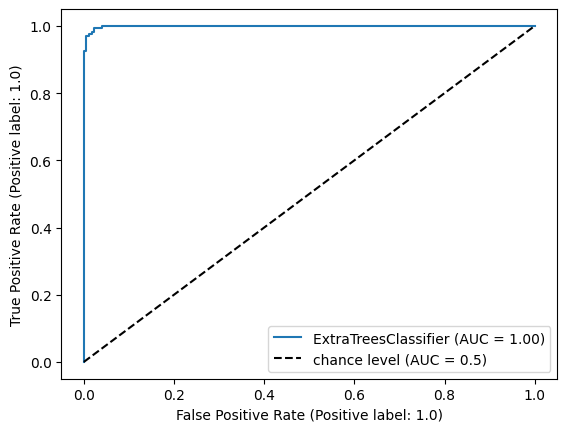

In [8]:
RocCurveDisplay.from_estimator(clf, X_imputed, y)
plt.plot([0, 1], [0,1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.show()

# Test Evaluation

In [ ]:
pred_probs = clf.predict_proba(X_test_imputed)
# Save the predictions to a CSV file
with open('sub_extra_tree_sk_%s.csv' % strategy, 'w') as fp:
    fp.write("Id,Predicted\n")
    for i, row in enumerate(pred_probs):
        if 0.48 <= row[1] <= 0.52:
            row[1] = random.choice([0.1, 0.9])
        fp.write(f"{i},{row[1]:.9f}\n")

# SHAP Values

In [9]:
k_explainer = shap.TreeExplainer(clf, X_imputed)
k_shap_values = k_explainer.shap_values(X_test_imputed)

 99%|===================| 282/286 [01:21<00:01]        

## Force Plots

In [37]:
main_feat = [2257, 2238, 646, 2254, 2231, 2186, 2201, 2215]

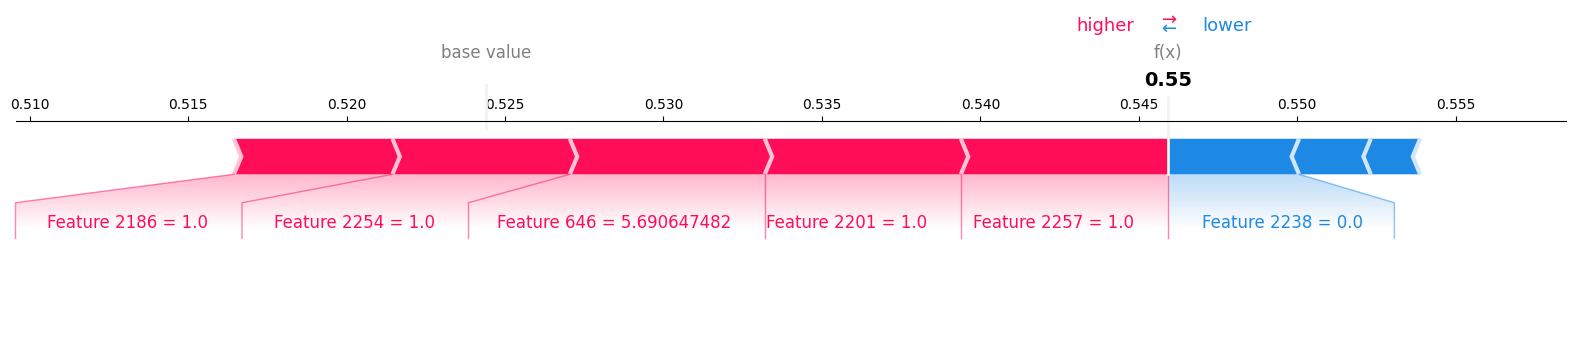

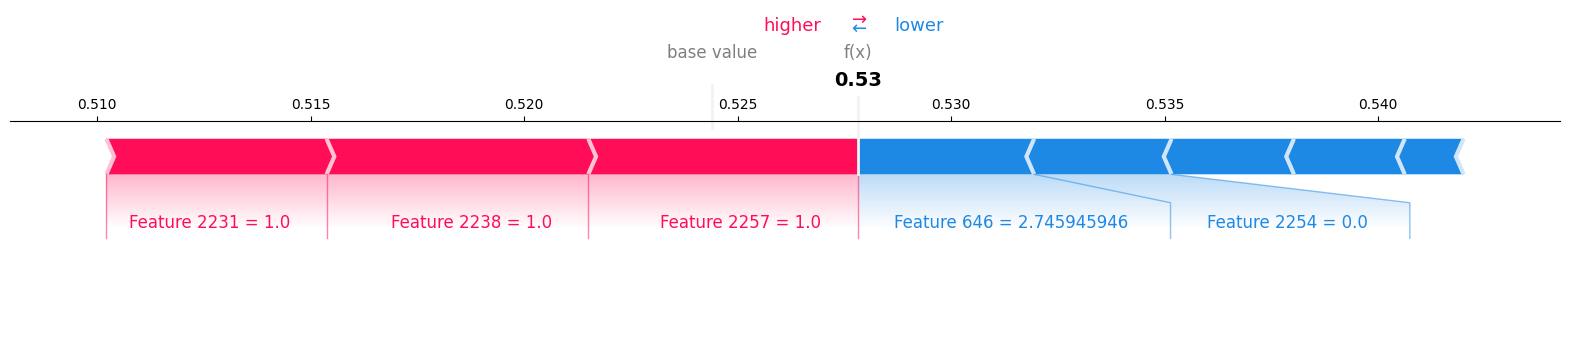

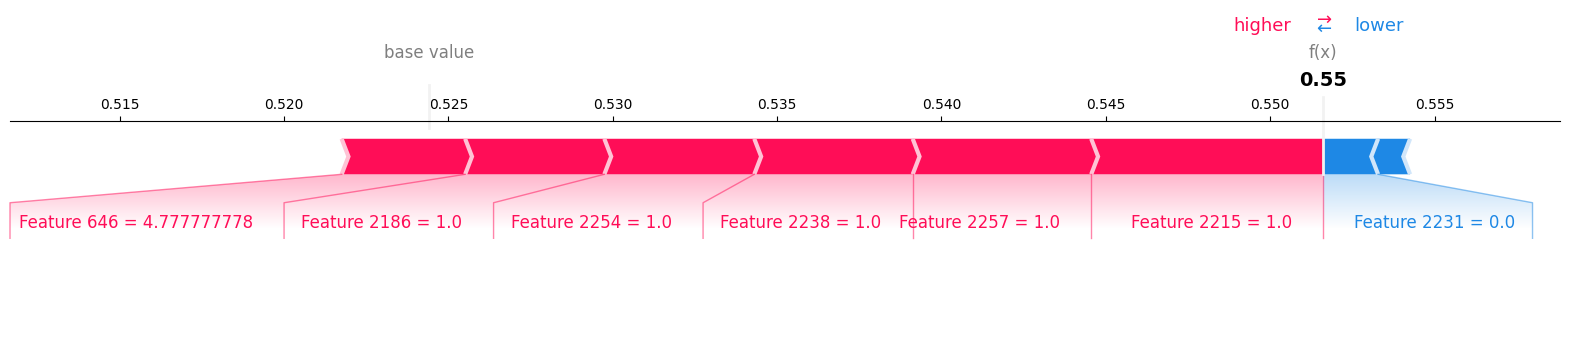

In [39]:
for idx in [5, 100, 140]:
    shap.force_plot(
        k_explainer.expected_value[1],
        k_shap_values[1][idx, main_feat],
        X_test_imputed[idx, main_feat],
        feature_names=[f"Feature {f}" for f in main_feat],
        matplotlib=True
    )
    plt.show()


## Summary Plot

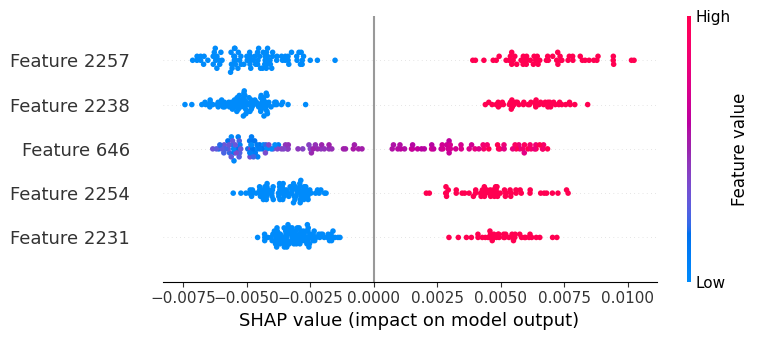

In [34]:
shap.summary_plot(k_shap_values[1], X_test_imputed, plot_type='dot', max_display=5)

## Force Plots

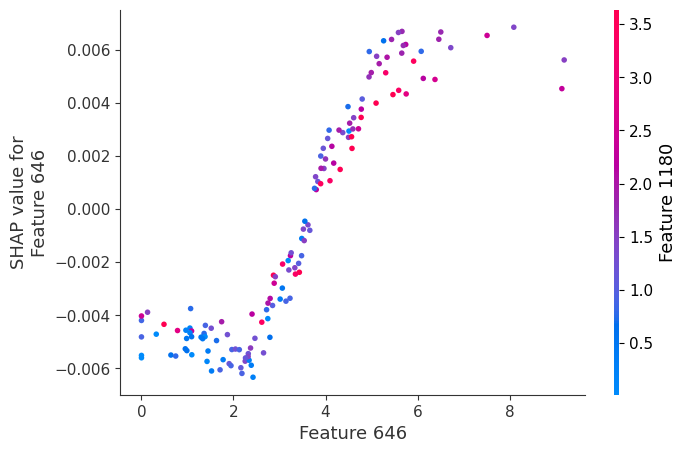

In [43]:
shap.dependence_plot(646, k_shap_values[1], X_test_imputed)

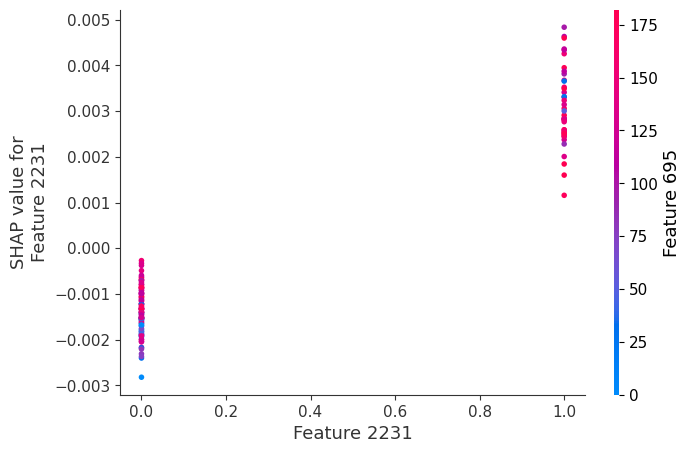

In [10]:
shap.dependence_plot(2231, k_shap_values[1], X_test_imputed)